# Imports

In [1]:
#Pandas, Numpy importieren
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sl
import scipy.stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

#Importeieren der Modelle aus verschiedenen Bibliotheken
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import GLS
from linearmodels.panel import PooledOLS


# Splitting data into training and testing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.model_selection import train_test_split

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 600)

# Matplotlib visualization
%matplotlib inline
# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize
#figsize(6, 6)

# Seaborn for visualization
sns.set(font_scale = 2)

# Import der Daten

In [2]:
pd.set_option('display.max_columns', 600)

data = pd.read_csv('../../data/math_imputed_2.csv')
data = data.sample(frac=1)

data.info()
#data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230 entries, 132 to 140
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LOCATION           230 non-null    object 
 1   SUBJECT            230 non-null    object 
 2   TIME               230 non-null    float64
 3   PISA Math          230 non-null    float64
 4   GINI               230 non-null    float64
 5   STR_SRY            230 non-null    float64
 6   CPI                230 non-null    float64
 7   ALC_PC             230 non-null    float64
 8   INTERNET_PC        230 non-null    float64
 9   HOMICIDES          230 non-null    float64
 10  log(MIGRANTS)      230 non-null    float64
 11  log(GDP)           230 non-null    float64
 12  log(EDU_SPENDING)  230 non-null    float64
 13  log(PCT_EDU_TRY)   230 non-null    float64
dtypes: float64(12), object(2)
memory usage: 27.0+ KB


# Benötigte Funktionen

## Methode zur Modellierung

In [3]:
'''
Params:  
    target: Variable, die vorhergesagt werden soll
    pexog_vars: liste der exogenen Variablen Bsp.: ['GINI', "log(GDP)", "HDI", "TIME", "LOCATION"]
    pX: Datensatz, auf dem die Kreuzvalidierung durchgeführt werden soll
    
'''

def modellieren(pexog_vars, pX, target):
    exog_vars = pexog_vars
    exog = sm.add_constant(pX[exog_vars])
    # data = data.drop(columns={"LOCATION", "TIME", "SUBJECT"})

    mod = PooledOLS(target, exog)

    pooled_res = mod.fit(cov_type='clustered', clusters=pX.LOCATION)
    
    r2_adj = (1-(((1 - pooled_res.rsquared)*(target.shape[0] - 1))/(target.shape[0]-(len(pexog_vars))-1)))
    print("R^2 adj.: ", r2_adj)
    
    return pooled_res

## Kreuzvalidierung

Die Kreuzvalidierung wird durchgeführt mit einer K-Fold Kreuzvalidierung. 

In [4]:
'''
Params: 
    n_splits: Anzahl der folds 
    target
    pexog_vars: liste der exogenen Variablen Bsp.: ['GINI', "log(GDP)", "HDI", "TIME", "LOCATION"]
    pX: Datensatz, auf dem die Kreuzvalidierung durchgeführt werden soll
    
'''



def k_fold_pooledOLS(n_splits, target, pexog_vars, pX):
    
#     #
#     exog_vars = pexog_vars.append("LOCATION", "TIME")
    features = pX
    
    
    # Splitten in der Reihenfolge der Reihen im df
    kf = KFold(n_splits, shuffle=True)
    r2 = np.zeros(n_splits)
    rmse = np.zeros(n_splits)
    r2_adj = np.zeros(n_splits)
    # print(r2)
    i=0

    for train_index, val_index in kf.split(features):
    #     print("%s %s" % (train_index, test_index))
        X_train, X_validate, y_train, y_validate = features.iloc[train_index], features.iloc[val_index], target.iloc[train_index], target.iloc[val_index]
        #print(X_train)
        
#         print(X_train)
        
        r2[i], rmse[i], r2_adj[i] = prediction(pexog_vars, X_train, y_train, X_validate,  y_validate)

    #     print(r2[i])
        i = i+1

    print("--------------------------- TOTAL ---------------------------------")
    print("R^2s: ", r2)
    # calculate mean of metrics
    print("R^2 mean: ", r2.mean())
    print("R^2 std: ", r2.std())
    
    print("\nR^2 adj.: ", r2_adj)
    # calculate mean of metrics
    print("R^2 adj. mean: ", r2_adj.mean())
    print("R^2 adj. std: ", r2_adj.std())
    
    print("\nRMSEs: ", rmse)
    # calculate mean of metrics
    print("RMSE mean: ", rmse.mean())
    print("RMSE std: ", rmse.std())

## Modell Vorhersage

In [5]:
'''
Params: 
    pexog_vars: liste der exogenen Variablen Bsp.: ['GINI', "log(GDP)", "HDI", "TIME", "LOCATION"]
    pX: 
    y_test: Y Werte des Testdatensatzes
    
'''



'''
R^2 ist NICHT out of sample => es ist das R^2 für das Modell auf den Trainingsdaten
R^2 ajd. ist NICHT out of sample => es ist das R^2 adj. für das Modell auf den Trainingsdaten
RSME ist out of sample => es ist das RMSE für das Modell auf den Testdaten
'''

def prediction(pexog_vars, pX, py, pX_test, py_test):

    #pX enthält Loaction Time Subejct
    exog = sm.add_constant(pX[pexog_vars])
    
#     print(py, exog)
    mod = PooledOLS(py, exog)

    pooled_res = mod.fit(cov_type='clustered', clusters=pX.LOCATION)
    #print(mod.predict(params=pooled_res.params, exog=X_test))
    
    
    # Prediction y^= X_test * beta
    x_pred = np.array(sm.add_constant(pX_test[pexog_vars]))
    
    b_pred = np.array(pooled_res.params)[0:len(pexog_vars)+1]

    y_pred = x_pred.dot(b_pred) 
    #print(y_pred)
    #print('\n')
    
    y_test = np.array(py_test)
    #print(y_test)
#     print('\n')
    squares = (y_pred-py_test)**2
    mse = (1/y_pred.shape[0])*(np.sum(squares))
    
#     print('Anzahl exogene Variablen: ', len(pexog_vars))
#     print('Anzahl Beobachtungen: ', y_pred.shape[0])
#     print('\n')
#     r2 = 1 - RSS/TSS
#     RSS = (np.sum(squares)
    
    # r^2 adj in-sample calculation
    r2_adj = (1-(((1 - pooled_res.rsquared)*(py.shape[0] - 1))/(py.shape[0]-(len(pexog_vars))-1)))
    
    
    ### 
   
    print('\nR^2 = ', pooled_res.rsquared)
    print('R^2 adj. = ', r2_adj)
#     print("MSE = ", mse)
    print("RMSE = ", np.sqrt(mse))
    
    return pooled_res.rsquared, np.sqrt(mse), r2_adj

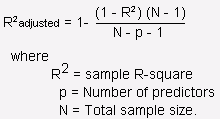

# Aufteilung der Daten in Train- & Testdatensatz

In [6]:
time = pd.Categorical(data["TIME"])
location = pd.Categorical(data["LOCATION"])
data = data.set_index(['LOCATION', 'TIME'])
data['TIME'] = time
data['LOCATION'] = location
# print(data)

features = data.drop(["PISA Math", "SUBJECT"], axis=1)
#PISA Math
X, X_test, y, y_test = train_test_split(features, data["PISA Math"], test_size = 0.1, random_state = 42)

#Festlegung der Parameter für die Modellierung methode
pX = X
target = y



# Nullmodell

In [7]:
pexog_vars = []

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.0


/Users/derboss/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


Dep. Variable:,PISA Math,R-squared:,0.0000
Estimator:,PooledOLS,R-squared (Between):,0.0000
No. Observations:,207,R-squared (Within):,0.0000
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.0000
Time:,11:49:38,Log-likelihood,-1062.8
Cov. Estimator:,Clustered,,
,,F-statistic:,--
Entities:,44,P-value,--
Avg Obs:,4.7045,Distribution:,--
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,--


# 1. Regressor

### Gini-Koeffizient

In [8]:
pexog_vars = ['GINI']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5282089137283955


Dep. Variable:,PISA Math,R-squared:,0.5305
Estimator:,PooledOLS,R-squared (Between):,0.5895
No. Observations:,207,R-squared (Within):,-0.1744
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.5305
Time:,11:49:39,Log-likelihood,-984.52
Cov. Estimator:,Clustered,,
,,F-statistic:,231.63
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(1,205)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,50.603


### BIP 

In [9]:
pexog_vars = ['log(GDP)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.4083853830753581


Dep. Variable:,PISA Math,R-squared:,0.4113
Estimator:,PooledOLS,R-squared (Between):,0.5777
No. Observations:,207,R-squared (Within):,-1.7279
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.4113
Time:,11:49:39,Log-likelihood,-1007.9
Cov. Estimator:,Clustered,,
,,F-statistic:,143.20
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(1,205)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,19.871


### CPI

In [10]:
pexog_vars = ['CPI']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.39658274895510315


Dep. Variable:,PISA Math,R-squared:,0.3995
Estimator:,PooledOLS,R-squared (Between):,0.4802
No. Observations:,207,R-squared (Within):,-0.4509
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.3995
Time:,11:49:39,Log-likelihood,-1010.0
Cov. Estimator:,Clustered,,
,,F-statistic:,136.39
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(1,205)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,21.060


### Anteil der 25-64 jährigen mit tertiärer Bildung

In [11]:
pexog_vars = ['log(PCT_EDU_TRY)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.4333628793099932


Dep. Variable:,PISA Math,R-squared:,0.4361
Estimator:,PooledOLS,R-squared (Between):,0.4829
No. Observations:,207,R-squared (Within):,-1.3893
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.4361
Time:,11:49:39,Log-likelihood,-1003.5
Cov. Estimator:,Clustered,,
,,F-statistic:,158.55
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(1,205)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,25.120


### Migration

In [12]:
pexog_vars = ['log(MIGRANTS)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.3763289314125904


Dep. Variable:,PISA Math,R-squared:,0.3794
Estimator:,PooledOLS,R-squared (Between):,0.5316
No. Observations:,207,R-squared (Within):,-0.2582
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.3794
Time:,11:49:39,Log-likelihood,-1013.4
Cov. Estimator:,Clustered,,
,,F-statistic:,125.30
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(1,205)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,15.830


### Mord Rate

In [13]:
pexog_vars = ['HOMICIDES']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.3214897206930498


Dep. Variable:,PISA Math,R-squared:,0.3248
Estimator:,PooledOLS,R-squared (Between):,0.3952
No. Observations:,207,R-squared (Within):,-0.6292
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.3248
Time:,11:49:39,Log-likelihood,-1022.1
Cov. Estimator:,Clustered,,
,,F-statistic:,98.606
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(1,205)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,31.455


### Alkohol Konsum pro Kopf

In [14]:
pexog_vars = ['ALC_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.32506381226901204


Dep. Variable:,PISA Math,R-squared:,0.3283
Estimator:,PooledOLS,R-squared (Between):,0.4349
No. Observations:,207,R-squared (Within):,-0.4885
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.3283
Time:,11:49:39,Log-likelihood,-1021.6
Cov. Estimator:,Clustered,,
,,F-statistic:,100.21
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(1,205)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,20.583


### Internet PC

In [15]:
pexog_vars = ['INTERNET_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.3195964833225665


Dep. Variable:,PISA Math,R-squared:,0.3229
Estimator:,PooledOLS,R-squared (Between):,0.4632
No. Observations:,207,R-squared (Within):,-3.5088
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.3229
Time:,11:49:39,Log-likelihood,-1022.4
Cov. Estimator:,Clustered,,
,,F-statistic:,97.762
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(1,205)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,22.769


### Bildungsausgaben im Sekundär Bereich

In [16]:
pexog_vars = ['log(EDU_SPENDING)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.3518974077780398


Dep. Variable:,PISA Math,R-squared:,0.3550
Estimator:,PooledOLS,R-squared (Between):,0.4016
No. Observations:,207,R-squared (Within):,-1.1132
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.3550
Time:,11:49:39,Log-likelihood,-1017.4
Cov. Estimator:,Clustered,,
,,F-statistic:,112.85
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(1,205)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,26.532


### Schüler, Lehrer Verhältnis

In [17]:
pexog_vars = ['STR_SRY']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.1590756196910471


Dep. Variable:,PISA Math,R-squared:,0.1632
Estimator:,PooledOLS,R-squared (Between):,0.2152
No. Observations:,207,R-squared (Within):,-0.1728
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.1632
Time:,11:49:40,Log-likelihood,-1044.3
Cov. Estimator:,Clustered,,
,,F-statistic:,39.969
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(1,205)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,7.3399


# 2. Regressor

### BIP

In [18]:
pexog_vars = ['GINI', 'log(GDP)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6105587178639011


Dep. Variable:,PISA Math,R-squared:,0.6143
Estimator:,PooledOLS,R-squared (Between):,0.7271
No. Observations:,207,R-squared (Within):,-0.7731
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.6143
Time:,11:49:40,Log-likelihood,-964.16
Cov. Estimator:,Clustered,,
,,F-statistic:,162.48
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(2,204)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,42.574


### CPI

In [19]:
pexog_vars = ['GINI', 'CPI']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6266705195411044


Dep. Variable:,PISA Math,R-squared:,0.6303
Estimator:,PooledOLS,R-squared (Between):,0.6945
No. Observations:,207,R-squared (Within):,-0.1516
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.6303
Time:,11:49:40,Log-likelihood,-959.79
Cov. Estimator:,Clustered,,
,,F-statistic:,173.90
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(2,204)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,34.032


### Anteil der 25-64 jährigen mit tertiärer Bildung

In [20]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.707391084710219


Dep. Variable:,PISA Math,R-squared:,0.7102
Estimator:,PooledOLS,R-squared (Between):,0.7807
No. Observations:,207,R-squared (Within):,-0.9694
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7102
Time:,11:49:40,Log-likelihood,-934.57
Cov. Estimator:,Clustered,,
,,F-statistic:,250.01
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(2,204)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,96.866


### Migration

In [21]:
pexog_vars = ['GINI', 'log(MIGRANTS)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6107525090257611


Dep. Variable:,PISA Math,R-squared:,0.6145
Estimator:,PooledOLS,R-squared (Between):,0.7134
No. Observations:,207,R-squared (Within):,-0.1783
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.6145
Time:,11:49:40,Log-likelihood,-964.11
Cov. Estimator:,Clustered,,
,,F-statistic:,162.61
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(2,204)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,61.859


### Mord Rate

In [22]:
pexog_vars = ['GINI', 'HOMICIDES']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5463072546078547


Dep. Variable:,PISA Math,R-squared:,0.5507
Estimator:,PooledOLS,R-squared (Between):,0.6116
No. Observations:,207,R-squared (Within):,-0.2000
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.5507
Time:,11:49:40,Log-likelihood,-979.97
Cov. Estimator:,Clustered,,
,,F-statistic:,125.03
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(2,204)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,56.528


### Alkohol Konsum pro Kopf

In [23]:
pexog_vars = ['GINI', 'ALC_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5960393423658124


Dep. Variable:,PISA Math,R-squared:,0.6000
Estimator:,PooledOLS,R-squared (Between):,0.6708
No. Observations:,207,R-squared (Within):,-0.1379
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.6000
Time:,11:49:41,Log-likelihood,-967.95
Cov. Estimator:,Clustered,,
,,F-statistic:,152.98
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(2,204)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,30.722


### Internet PC

In [24]:
pexog_vars = ['GINI', 'INTERNET_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5932029171012199


Dep. Variable:,PISA Math,R-squared:,0.5972
Estimator:,PooledOLS,R-squared (Between):,0.6982
No. Observations:,207,R-squared (Within):,-1.3501
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.5972
Time:,11:49:41,Log-likelihood,-968.68
Cov. Estimator:,Clustered,,
,,F-statistic:,151.20
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(2,204)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,37.283


### Bildungsausgaben im Sekundar Bereich

In [25]:
pexog_vars = ['GINI', 'log(EDU_SPENDING)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5905220074613255


Dep. Variable:,PISA Math,R-squared:,0.5945
Estimator:,PooledOLS,R-squared (Between):,0.6387
No. Observations:,207,R-squared (Within):,-0.3614
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.5945
Time:,11:49:41,Log-likelihood,-969.35
Cov. Estimator:,Clustered,,
,,F-statistic:,149.54
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(2,204)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,34.469


### Schüler, Lehrer Verhältnis

In [26]:
pexog_vars = ['GINI', 'STR_SRY']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5267859173137742


Dep. Variable:,PISA Math,R-squared:,0.5314
Estimator:,PooledOLS,R-squared (Between):,0.5888
No. Observations:,207,R-squared (Within):,-0.1925
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.5314
Time:,11:49:41,Log-likelihood,-984.33
Cov. Estimator:,Clustered,,
,,F-statistic:,115.66
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(2,204)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,25.089


# 3. Regressor

### BIP

In [27]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'log(GDP)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7060181508554435


Dep. Variable:,PISA Math,R-squared:,0.7103
Estimator:,PooledOLS,R-squared (Between):,0.7828
No. Observations:,207,R-squared (Within):,-0.9833
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7103
Time:,11:49:41,Log-likelihood,-934.55
Cov. Estimator:,Clustered,,
,,F-statistic:,165.91
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(3,203)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,71.426


### CPI

In [28]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'CPI']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7223844546417904


Dep. Variable:,PISA Math,R-squared:,0.7264
Estimator:,PooledOLS,R-squared (Between):,0.7928
No. Observations:,207,R-squared (Within):,-0.6693
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7264
Time:,11:49:42,Log-likelihood,-928.62
Cov. Estimator:,Clustered,,
,,F-statistic:,179.68
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(3,203)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,60.222


### Migration

In [29]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'log(MIGRANTS)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7086389594180451


Dep. Variable:,PISA Math,R-squared:,0.7129
Estimator:,PooledOLS,R-squared (Between):,0.7901
No. Observations:,207,R-squared (Within):,-0.8738
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7129
Time:,11:49:42,Log-likelihood,-933.62
Cov. Estimator:,Clustered,,
,,F-statistic:,168.01
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(3,203)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,77.426


### Alkohol Konsum pro Kopf 

In [30]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7416093403171315


Dep. Variable:,PISA Math,R-squared:,0.7454
Estimator:,PooledOLS,R-squared (Between):,0.8086
No. Observations:,207,R-squared (Within):,-0.6504
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7454
Time:,11:49:42,Log-likelihood,-921.19
Cov. Estimator:,Clustered,,
,,F-statistic:,198.08
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(3,203)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,76.144


### Mord Rate

In [31]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'HOMICIDES']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7225894558225823


Dep. Variable:,PISA Math,R-squared:,0.7266
Estimator:,PooledOLS,R-squared (Between):,0.8014
No. Observations:,207,R-squared (Within):,-0.9669
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7266
Time:,11:49:42,Log-likelihood,-928.55
Cov. Estimator:,Clustered,,
,,F-statistic:,179.86
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(3,203)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,180.93


### Internet PC

In [32]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'INTERNET_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7084132544167077


Dep. Variable:,PISA Math,R-squared:,0.7127
Estimator:,PooledOLS,R-squared (Between):,0.7734
No. Observations:,207,R-squared (Within):,-0.7465
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7127
Time:,11:49:42,Log-likelihood,-933.70
Cov. Estimator:,Clustered,,
,,F-statistic:,167.83
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(3,203)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,69.156


### Bildungsausgaben im Sekundar Bereich

In [33]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'log(EDU_SPENDING)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.719902600093637


Dep. Variable:,PISA Math,R-squared:,0.7240
Estimator:,PooledOLS,R-squared (Between):,0.7840
No. Observations:,207,R-squared (Within):,-0.8806
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7240
Time:,11:49:42,Log-likelihood,-929.54
Cov. Estimator:,Clustered,,
,,F-statistic:,177.49
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(3,203)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,68.681


### Schüler, Lehrer Verhältnis

In [34]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'STR_SRY']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7077100564503981


Dep. Variable:,PISA Math,R-squared:,0.7120
Estimator:,PooledOLS,R-squared (Between):,0.7801
No. Observations:,207,R-squared (Within):,-0.9878
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7120
Time:,11:49:42,Log-likelihood,-933.95
Cov. Estimator:,Clustered,,
,,F-statistic:,167.26
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(3,203)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,64.203


# 4. Regressor

### BIP

In [35]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'log(GDP)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7406093601095194


Dep. Variable:,PISA Math,R-squared:,0.7456
Estimator:,PooledOLS,R-squared (Between):,0.8123
No. Observations:,207,R-squared (Within):,-0.6709
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7456
Time:,11:49:42,Log-likelihood,-921.08
Cov. Estimator:,Clustered,,
,,F-statistic:,148.04
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(4,202)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,57.293


### Bildungsausgaben

In [36]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'log(EDU_SPENDING)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7414376329335233


Dep. Variable:,PISA Math,R-squared:,0.7465
Estimator:,PooledOLS,R-squared (Between):,0.8069
No. Observations:,207,R-squared (Within):,-0.6415
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7465
Time:,11:49:42,Log-likelihood,-920.75
Cov. Estimator:,Clustered,,
,,F-statistic:,148.68
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(4,202)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,58.490


### Migration

In [37]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'log(MIGRANTS)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7403520884120744


Dep. Variable:,PISA Math,R-squared:,0.7454
Estimator:,PooledOLS,R-squared (Between):,0.8093
No. Observations:,207,R-squared (Within):,-0.6443
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7454
Time:,11:49:43,Log-likelihood,-921.19
Cov. Estimator:,Clustered,,
,,F-statistic:,147.85
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(4,202)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,58.094


### CPI

In [38]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'CPI']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7606773775104676


Dep. Variable:,PISA Math,R-squared:,0.7653
Estimator:,PooledOLS,R-squared (Between):,0.8247
No. Observations:,207,R-squared (Within):,-0.3882
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7653
Time:,11:49:43,Log-likelihood,-912.75
Cov. Estimator:,Clustered,,
,,F-statistic:,164.69
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(4,202)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,54.945


### Internet PC

In [39]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'INTERNET_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7403620979259655


Dep. Variable:,PISA Math,R-squared:,0.7454
Estimator:,PooledOLS,R-squared (Between):,0.8076
No. Observations:,207,R-squared (Within):,-0.6303
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7454
Time:,11:49:43,Log-likelihood,-921.18
Cov. Estimator:,Clustered,,
,,F-statistic:,147.85
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(4,202)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,58.737


### Mordrate

In [40]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'HOMICIDES']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7771824741948038


Dep. Variable:,PISA Math,R-squared:,0.7815
Estimator:,PooledOLS,R-squared (Between):,0.8461
No. Observations:,207,R-squared (Within):,-0.6032
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7815
Time:,11:49:43,Log-likelihood,-905.35
Cov. Estimator:,Clustered,,
,,F-statistic:,180.63
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(4,202)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,110.06


### Schüler, Lehrer Verhältnis

In [41]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'STR_SRY']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.746005130948324


Dep. Variable:,PISA Math,R-squared:,0.7509
Estimator:,PooledOLS,R-squared (Between):,0.8095
No. Observations:,207,R-squared (Within):,-0.6664
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7509
Time:,11:49:43,Log-likelihood,-918.91
Cov. Estimator:,Clustered,,
,,F-statistic:,152.26
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(4,202)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,60.751


# 5. Regressor

### BIP

In [42]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'HOMICIDES', 'log(GDP)'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7771061072491824


Dep. Variable:,PISA Math,R-squared:,0.7825
Estimator:,PooledOLS,R-squared (Between):,0.8410
No. Observations:,207,R-squared (Within):,-0.5645
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7825
Time:,11:49:43,Log-likelihood,-904.87
Cov. Estimator:,Clustered,,
,,F-statistic:,144.64
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(5,201)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,84.896


### Bildungsausgaben

In [43]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'HOMICIDES', 'log(EDU_SPENDING)'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7786252893614801


Dep. Variable:,PISA Math,R-squared:,0.7840
Estimator:,PooledOLS,R-squared (Between):,0.8456
No. Observations:,207,R-squared (Within):,-0.5978
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7840
Time:,11:49:43,Log-likelihood,-904.17
Cov. Estimator:,Clustered,,
,,F-statistic:,145.91
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(5,201)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,92.176


### Migration

In [44]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'HOMICIDES', 'log(MIGRANTS)'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.779240579246968


Dep. Variable:,PISA Math,R-squared:,0.7846
Estimator:,PooledOLS,R-squared (Between):,0.8433
No. Observations:,207,R-squared (Within):,-0.6847
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7846
Time:,11:49:43,Log-likelihood,-903.88
Cov. Estimator:,Clustered,,
,,F-statistic:,146.43
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(5,201)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,78.861


### Internet PC

In [45]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'HOMICIDES', 'INTERNET_PC'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7763427224931879


Dep. Variable:,PISA Math,R-squared:,0.7818
Estimator:,PooledOLS,R-squared (Between):,0.8439
No. Observations:,207,R-squared (Within):,-0.5542
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7818
Time:,11:49:43,Log-likelihood,-905.23
Cov. Estimator:,Clustered,,
,,F-statistic:,144.01
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(5,201)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,90.397


### CPI

In [46]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'HOMICIDES', 'CPI'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7847068599476534


Dep. Variable:,PISA Math,R-squared:,0.7899
Estimator:,PooledOLS,R-squared (Between):,0.8503
No. Observations:,207,R-squared (Within):,-0.4256
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7899
Time:,11:49:44,Log-likelihood,-901.28
Cov. Estimator:,Clustered,,
,,F-statistic:,151.17
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(5,201)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,79.034


### Schüler, Lehrer Verhältnis

In [47]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'HOMICIDES', 'STR_SRY'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7810500810132558


Dep. Variable:,PISA Math,R-squared:,0.7864
Estimator:,PooledOLS,R-squared (Between):,0.8516
No. Observations:,207,R-squared (Within):,-0.6091
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7864
Time:,11:49:44,Log-likelihood,-903.03
Cov. Estimator:,Clustered,,
,,F-statistic:,147.97
Entities:,44,P-value,0.0000
Avg Obs:,4.7045,Distribution:,"F(5,201)"
Min Obs:,0.0000,,
Max Obs:,7.0000,F-statistic (robust):,89.142


# Validierung des Modells

In [48]:
n_splits = 4
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'HOMICIDES'] 

k_fold_pooledOLS(n_splits, target, pexog_vars, pX)


R^2 =  0.8090593610128459
R^2 adj. =  0.8039676106398551
RMSE =  23.393796802070067

R^2 =  0.7943964683017981
R^2 adj. =  0.7889137074565127
RMSE =  17.955693159031494

R^2 =  0.7387380685498159
R^2 adj. =  0.7317710837111444
RMSE =  17.50160319642322

R^2 =  0.785614299381463
R^2 adj. =  0.7799352079743495
RMSE =  19.62483825469457
--------------------------- TOTAL ---------------------------------
R^2s:  [0.80905936 0.79439647 0.73873807 0.7856143 ]
R^2 mean:  0.7819520493114808
R^2 std:  0.026317912723685753

R^2 adj.:  [0.80396761 0.78891371 0.73177108 0.77993521]
R^2 adj. mean:  0.7761469024454654
R^2 adj. std:  0.02702104578726077

RMSEs:  [23.3937968  17.95569316 17.5016032  19.62483825]
RMSE mean:  19.61898285305484
RMSE std:  2.3183552279563426


# Anwendung des Modells auf die Testdaten

In [49]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'HOMICIDES'] 
prediction(pexog_vars, pX, target, X_test, y_test)


R^2 =  0.7815090280939339
R^2 adj. =  0.7771824741948038
RMSE =  18.932771664086026


(0.7815090280939339, 18.932771664086026, 0.7771824741948038)

Regressoren:
1. Gini
2. log(PCT_EDU_TRY)
3. ALC_PC
4. HOMICIDES

Keine Hinzunahmen weiterer Regressoren, damit die jetzigen Variablen signifikant bleiben.